In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=0


In [87]:
import glob
from collections import defaultdict

In [25]:
import os, sys
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from pandas import DataFrame
import torch, torch.nn as nn
import numpy as np
import random
import networkx as nx
from utils_mcts import *
from MCTS_Act_LSTM import MCTS
from problem_mcts import GraphProblem, generate_erdos_renyi_problems, generate_regular_problems
from network_mcts import AgentActLSTM
import time

In [3]:
sys.path.insert(0, '..')
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [4]:
def replace(P, source, target):
    '''Replace last occurrence of source with source-target-source.'''
    assert source in P
    ix = len(P) - P[::-1].index(source)
    return P[:ix] + [target, P[ix - 1]] + P[ix:]

In [5]:
def covering_walk(graph, source):
    P = [0]  # supporting walk
    S = [0]  # stack of nodes to check
    node2anon = {source: 0}
    anon2node = {0: source}
    checked = dict()  # nodes that has been checked for edge
    degrees = graph.degree()
    while len(S) > 0:  # grow supporting walk in DFS manner
        curr = S[-1]
        x = max(P) + 1  # next node to check

        # check if there is a node in the neighborhood that has not been explored yet
        Ncurr = list(nx.neighbors(graph, anon2node[curr]))
        if random.uniform(0, 1) < 0.99:
            random.shuffle(Ncurr)  # option 1: random order
        else:
            Ncurr = sorted(Ncurr, key=lambda v: degrees[v], reverse=True)  # option 2: top-degree
            # Ncurr = sorted(Ncurr, key=lambda v: degrees[v], reverse=False)  # option 3: low-degree
        # print(anon2node[curr], Ncurr)
        for neighbor in Ncurr:
            if neighbor in node2anon:
                continue  # already visited
            else:
                node2anon[neighbor] = x
                anon2node[x] = neighbor
                S.append(x)
                checked.setdefault(curr, set()).add(x)
                P = replace(P, curr, x)  # move to it
                break
        else:
            S.pop()  # move back in the stack

        for u in range(x-1, curr, -1):  # u is already in the supporting walk
            # check if there is connection to already discovered nodes
            if u not in checked[curr]:  # see if we already checked this edge
                if anon2node[u] in graph[anon2node[curr]]:
                    P = replace(P, curr, u)
                checked.setdefault(curr, set()).add(u)

    cover = [anon2node[v] for v in P]
    return cover, P

In [6]:
#params
NUM_PROBLEMS = 10
NUM_EPISODES = 10
BATCH_SIZE = 32
NUM_MCSIMS = 5
NUM_UPDATES = 5
NUM_VERTICES = 15
DEGREE = 6
CPUCT = 1.0
THRESHOLD = 0.75
PATHS_BUFFER_CAPACITY = 1000
REPLAY_BUFFER_CAPACITY = 10000

In [7]:
moving_average = lambda x, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

In [8]:
#generate regular train graphs (n=15, d=6)
problem_maker = generate_regular_problems(num_vertices=NUM_VERTICES, degree=DEGREE)

In [9]:
#initialize agent
agent = AgentActLSTM(hid_size=256, gcn_size=256, vertex_emb_size=64)

In [10]:
optimizer = torch.optim.Adam(agent.parameters(), lr=1e-4)

In [11]:
#initialize buffers
path_buffer = PathsBuffer(capacity=PATHS_BUFFER_CAPACITY, threshold=THRESHOLD)
train_buffer = ReplayBuffer(capacity=REPLAY_BUFFER_CAPACITY)

In [12]:
# loss stats
pi_losses_history = []
v_losses_history = []

In [13]:
problems = [next(problem_maker) for i in range(NUM_PROBLEMS)]

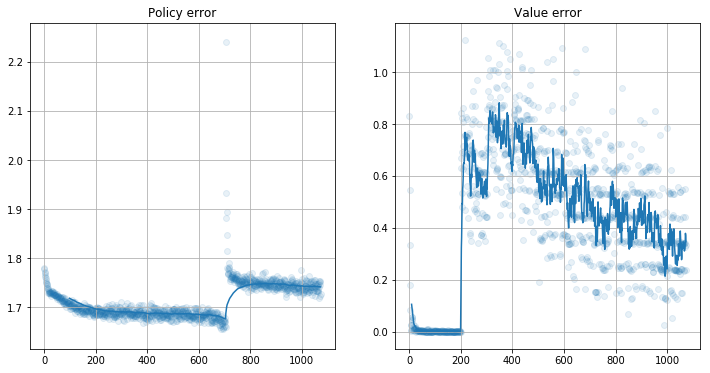

KeyboardInterrupt: 

In [14]:
i = 0
for k in trange(len(problems)):
    
    problem = problems[k]
    
    edges = problem.get_edges()
    
    """
    for i in range(20):
        cover, _ = covering_walk(problem.nx_graph, random.sample(list(problem.edges.keys()), 1)[0])
        path_buffer.push(cover)
    """
    
    for vertex in problem.get_actions():
        
        path_buffer.flush()
        
        PATH_LENGTH = 2*problem.num_edges + 1        
        
        i += 1 
    
        for episode in range(NUM_EPISODES):
        
            with torch.no_grad():
                graph_emb = agent.embed_graph(problem.edges)
                
            problem.path = [vertex]

            path = problem.get_state()
        
            mcts = MCTS(game=problem, nnet=agent, graph_emb=graph_emb,
                    numMCTSSims=NUM_MCSIMS, cpuct=CPUCT, edges=edges, path_length=PATH_LENGTH)

            trainExamples = []
        
            while len(path) != PATH_LENGTH:
                with torch.no_grad():
                    pi = mcts.getActionProb(path, path_buffer)
                trainExamples.append([path, pi, None])
                
                vertex = np.random.choice(edges[path[-1]], p=pi)
                
                path = problem.get_next_state(path, vertex)
                
            path_buffer.push(path)
        
            if len(path_buffer) >= 10: 
                r = path_buffer.rank_path(path)
                for x in trainExamples:
                    x[-1] = r
                train_buffer.push(trainExamples)
            
            if len(train_buffer) >= BATCH_SIZE:
                print("Start training!")
                for i in range(NUM_UPDATES):
                    batch = train_buffer.sample(BATCH_SIZE)
                    paths, pis, vs = zip(*batch)
                    graph_emb = agent.embed_graph(problem.edges)
                    out_pi, out_v = agent.get_dist(paths, graph_emb, edges)
                
                    target_vs = torch.tensor(vs)
                
                    losses_pi = []
                    for i, p in enumerate(pis):
                        losses_pi.append(torch.tensor(p)*torch.log(out_pi[i]))
            
                    loss_pi = -torch.sum(torch.stack(losses_pi))/len(pis)
                    loss_v = torch.sum((target_vs-out_v.view(-1))**2)/target_vs.size()[0]
                    total_loss = loss_pi + loss_v

                    pi_losses_history.append(loss_pi.item())
                    v_losses_history.append(loss_v.item())

                    optimizer.zero_grad()
                    total_loss.backward()
                    optimizer.step()

                    clear_output(True)
                    plt.figure(figsize=[12, 6])
                    plt.subplot(1,2,1)
                    plt.title('Policy error'); plt.grid()
                    plt.scatter(np.arange(len(pi_losses_history)), pi_losses_history, alpha=0.1)
                    plt.plot(moving_average(pi_losses_history, span=100, min_periods=100))
    
                    plt.subplot(1,2,2)
                    plt.title('Value error'); plt.grid()
                    plt.scatter(np.arange(len(v_losses_history)), v_losses_history, alpha=0.1)
                    plt.plot(moving_average(v_losses_history, span=10, min_periods=10))
                    plt.show()

In [16]:
agent

AgentActLSTM(
  (gcn): GraphConvolutionBlock(
    (convs): ModuleList(
      (0): GraphConvolution (64 -> 256)
      (1): GraphConvolution (256 -> 256)
    )
    (activation): ELU(alpha=1.0)
    (dense): Linear(in_features=256, out_features=256, bias=True)
  )
  (lstm): LSTM(256, 256, batch_first=True)
  (critic): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=1, bias=True)
  )
  (actor): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): Softmax()
  )
)

In [22]:
def test_agent(agent, problem, vertex):
    problem.path = [vertex]
    edges = problem.get_edges()
    path = problem.get_state()
    PATH_LENGTH = 2*problem.num_edges + 1
    with torch.no_grad():
        graph_emb = agent.embed_graph(problem.edges)
        mcts = MCTS(game=problem, nnet=agent, graph_emb=graph_emb,
                    numMCTSSims=NUM_MCSIMS, cpuct=CPUCT, edges=edges, path_length=PATH_LENGTH)
        while len(path) != PATH_LENGTH:
            pi = mcts.getActionProb(path, path_buffer)
            vertex = np.random.choice(edges[path[-1]], p=pi)
            path = problem.get_next_state(path, vertex)
    return path

In [24]:
G = nx.random_regular_graph(6, 15)
G2 = relabel_graph(G)
print(15, graph_isomorphism_algorithm_covers(G, G2, agent, test_agent, 1))

15 False


In [30]:
os.listdir("./experiments_datasets/erdosrenyi")

['.DS_Store',
 'er_graphs_n90_d5',
 'er_graphs_n80_d5',
 'er_graphs_n100_d5',
 'er_graphs_n10_d5',
 'er_graphs_n30_d5',
 'er_graphs_n20_d5',
 'er_graphs_n60_d5',
 'er_graphs_n70_d5',
 'er_graphs_n50_d5',
 'er_graphs_n40_d5']

In [37]:
nx.read_edgelist("./experiments_datasets/erdosrenyi/")

IsADirectoryError: [Errno 21] Is a directory: './experiments_datasets/erdosrenyi/'

In [39]:
for name in glob.glob("./experiments_datasets/erdosrenyi/er_graphs_n90_d5/"):
    print(name)

./experiments_datasets/erdosrenyi/er_graphs_n90_d5/


In [92]:
def generate_graphs(path, n_graphs):
    graphs = []
    samples = random.sample(glob.glob(path+"/*"), n_graphs)
    for sample in samples:
        graph_path = random.sample(glob.glob(sample+"/9?.edgelist"),1)
        with open(graph_path[0], "rb") as f:
            graph = nx.read_edgelist(f)
            graph_edges = defaultdict(set)
            num_edges = 0
            nx_graph = graph
            for v1, v2 in graph.edges:
                graph_edges[v1].add(v2)
                graph_edges[v2].add(v1)
                num_edges += 1
        graphs.append(GraphProblem(graph_edges, 0, num_edges, nx_graph))
    return graphs

In [93]:
g = generate_graphs("./experiments_datasets/erdosrenyi", 10)

In [94]:
print(g)

[<problem_mcts.GraphProblem object at 0xa2ba54fd0>, <problem_mcts.GraphProblem object at 0xa2bac21d0>, <problem_mcts.GraphProblem object at 0xa2bbe8240>, <problem_mcts.GraphProblem object at 0xa2bc2aac8>, <problem_mcts.GraphProblem object at 0xa2bc7b710>, <problem_mcts.GraphProblem object at 0xa2bb045c0>, <problem_mcts.GraphProblem object at 0xa2bba1ef0>, <problem_mcts.GraphProblem object at 0xa2bbb5630>, <problem_mcts.GraphProblem object at 0xa2bbc8b70>, <problem_mcts.GraphProblem object at 0xa2bb5a550>]


In [77]:
x = graphs[0]

In [83]:
x.edges()

EdgeView([('0', '9'), ('0', '11'), ('0', '19'), ('9', '3'), ('9', '6'), ('9', '11'), ('9', '17'), ('9', '18'), ('9', '10'), ('11', '1'), ('11', '19'), ('19', '2'), ('19', '14'), ('1', '2'), ('1', '14'), ('1', '16'), ('2', '3'), ('2', '6'), ('2', '8'), ('2', '15'), ('2', '18'), ('14', '7'), ('14', '12'), ('14', '13'), ('14', '18'), ('16', '18'), ('3', '4'), ('3', '6'), ('3', '18'), ('6', '8'), ('8', '13'), ('15', '12'), ('15', '17'), ('18', '12'), ('5', '12')])